APS-FAILURE PREDICTION


In [5]:
import pandas as pd
import numpy as np

In [6]:
df=pd.read_csv(r'https://raw.githubusercontent.com/avnyadav/sensor-fault-detection/main/aps_failure_training_set1.csv',na_values="na")

In [7]:
df.shape

(36188, 171)

In [8]:
import pandas as pd
import seaborn as sns
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import PowerTransformer
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve,confusion_matrix


from sklearn import metrics 
from sklearn.model_selection import  train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier

warnings.filterwarnings("ignore")
%matplotlib inline

In [9]:
# Check unique values of target varaible
df['class'].value_counts()

class
neg    35188
pos     1000
Name: count, dtype: int64

In [10]:
df.dtypes

class      object
aa_000      int64
ab_000    float64
ac_000    float64
ad_000    float64
           ...   
ee_007    float64
ee_008    float64
ee_009    float64
ef_000    float64
eg_000    float64
Length: 171, dtype: object

In [11]:
# define numerical & categorical columns
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']

# print columns
print('We have {} numerical features : {}'.format(len(numeric_features), numeric_features))
print('\nWe have {} categorical features : {}'.format(len(categorical_features), categorical_features))

We have 170 numerical features : ['aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000', 'ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'ah_000', 'ai_000', 'aj_000', 'ak_000', 'al_000', 'am_0', 'an_000', 'ao_000', 'ap_000', 'aq_000', 'ar_000', 'as_000', 'at_000', 'au_000', 'av_000', 'ax_000', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'bb_000', 'bc_000', 'bd_000', 'be_000', 'bf_000', 'bg_000', 'bh_000', 'bi_000', 'bj_000', 'bk_000', 'bl_000', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'bs_000', 'bt_000', 'bu_000', 'bv_000', 'bx_000', 'by_000', 'bz_000', 'ca_000', 'cb_000', 'cc_000', 'cd_000', 'ce_000', 'cf_000', 'cg_000', 'ch_000', 'ci_000', 'cj_000', 'ck_000'

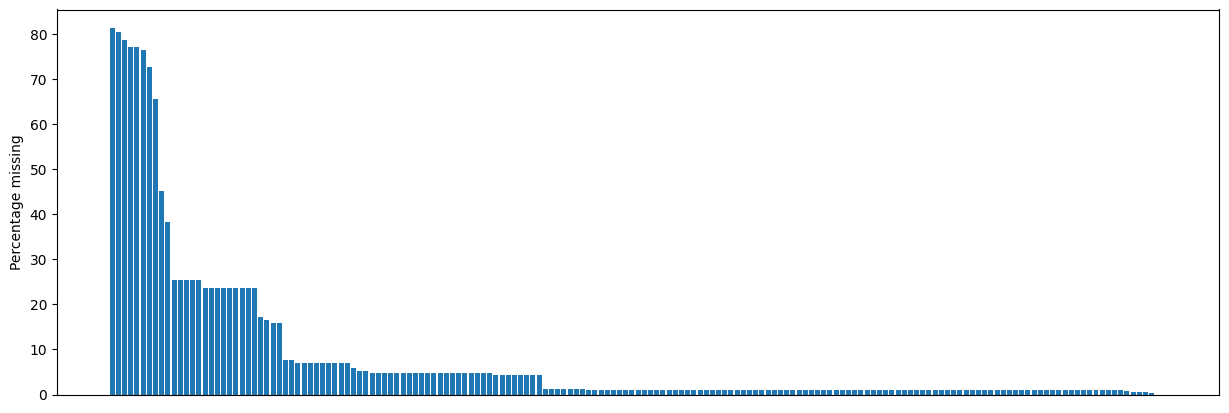

In [12]:
# Plotting Missing values count for each column
fig, ax = plt.subplots(figsize=(15,5))

missing = df.isna().sum().div(df.shape[0]).mul(100).to_frame().sort_values(by=0, ascending = False)

ax.bar(missing.index, missing.values.T[0])
plt.xticks([])
plt.ylabel("Percentage missing")
plt.show()

In [13]:
## Dropping columns which has more than 70% of missing values
dropcols = missing[missing[0]>70]
dropcols

,0
br_000,81.410965
bq_000,80.501824
bp_000,78.794075
cr_000,77.086327
ab_000,77.086327
bo_000,76.533658
bn_000,72.761689


In [14]:
df.drop(list(dropcols.index), axis=1, inplace=True)

In [15]:
# Check shape of the dataset after dropping columns
df.shape

(36188, 164)

Positive: 1000, Negative: 35188


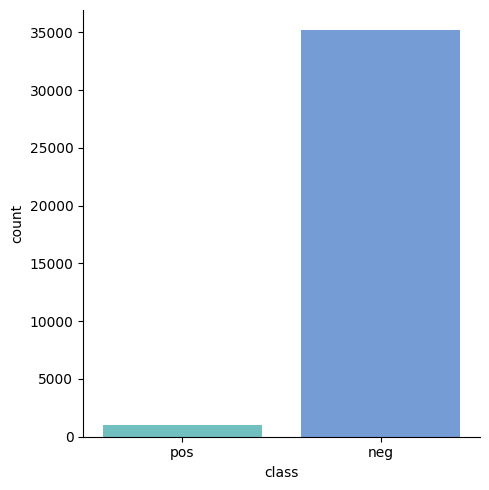

In [16]:
pos = df[df['class']=='pos'].shape[0]
neg = df[df['class']=='neg'].shape[0]
print("Positive: " + str(pos) + ", Negative: " + str(neg))
sns.catplot(data=df, x="class", kind="count", palette="winter_r", alpha=.6)
plt.show()

In [17]:
def evaluate_clf(true, predicted):
    '''
    This function takes in true values and predicted values
    Returns: Accuracy, F1-Score, Precision, Recall, Roc-auc Score
    '''
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

In [18]:
# Create cost of the model as per data description
def total_cost(y_true, y_pred):
    '''
    This function takes y_ture, y_predicted, and prints Total cost due to misclassification
   
    '''
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = 10*fp + 500*fn
    return cost

In [19]:
# Create a function to evaluate models and return a report
def evaluate_models(X_train, y_train, X_test, y_test, models):
    '''
    This function takes in X_train, y_train, X_test, y_test, and a models dictionary as input.
    It iterates through the given model dictionary and evaluates the metrics.
    Returns: Dataframe which contains a report of all models' metrics with cost.
    '''
    cost_list = []
    models_list = []
    
    # Iterate over the model dictionary
    for model_name, model in models.items():
        # Train model
        model.fit(X_train, y_train)

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Evaluate training set performance
        model_train_accuracy, model_train_f1, model_train_precision, \
        model_train_recall, model_train_rocauc_score = evaluate_clf(y_train, y_train_pred)
        train_cost = total_cost(y_train, y_train_pred)

        # Evaluate test set performance
        model_test_accuracy, model_test_f1, model_test_precision, \
        model_test_recall, model_test_rocauc_score = evaluate_clf(y_test, y_test_pred)
        test_cost = total_cost(y_test, y_test_pred)

        # Store model name and test cost
        models_list.append(model_name)
        cost_list.append(test_cost)

        # Display metrics
        print(model_name)
        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))
        print(f'- COST: {train_cost}.')
        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        print(f'- COST: {test_cost}.')
        print('=' * 35)
        print('\n')

    # Create a report DataFrame
    report = pd.DataFrame(list(zip(models_list, cost_list)), columns=['Model Name', 'Cost']).sort_values(by=["Cost"])

    return report


In [16]:
# numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']

# plt.figure(figsize=(15, 100))
# for i, col in enumerate(numeric_features):
#     plt.subplot(60, 3, i+1)
#     sns.distplot(x=df[col], color='indianred')
#     plt.xlabel(col, weight='bold')
#     plt.tight_layout()

In [20]:
# Splitting X and y for all Experiments
X= df.drop('class', axis=1)
y = df['class']

In [21]:
y= y.replace({'pos': 1, 'neg': 0})

In [22]:
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1,stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1,stratify=y_train) # 0.25 x 0.8 = 0.2

**Different Models**

In [23]:
# Dictionary which contains models for experiment
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
    "K-Neighbors Classifier": KNeighborsClassifier(),
    # Enable GPU for XGBoost
    "XGBClassifier": XGBClassifier(tree_method='gpu_hist', gpu_id=0, predictor='gpu_predictor'),
    # Enable GPU for CatBoost
    "CatBoosting Classifier": CatBoostClassifier(devices='0', task_type='GPU', verbose=False), 
                                                 
    "AdaBoost Classifier": AdaBoostClassifier()
}

**Experiment-1-> with KNN imputer**

In [68]:
results=[]
# define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
strategies = [str(i) for i in [1,3,5,7,9]]
for s in strategies:
    pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', LogisticRegression())])
    scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=2, n_jobs=-1)
    results.append(scores)
    print('n_neighbors= %s || accuracy (%.4f)' % (s , mean(scores)))

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

n_neighbors= 1 || accuracy (0.9845)


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

n_neighbors= 3 || accuracy (0.9854)


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

n_neighbors= 5 || accuracy (0.9863)


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

n_neighbors= 7 || accuracy (0.9857)


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

n_neighbors= 9 || accuracy (0.9859)


For n_neigbours=5 the accuracy is the highest

Pipeline for KNN 

In [69]:
num_features = X_train.select_dtypes(exclude="object").columns

# Fit the KNN imputer with selected K-value
knn_pipeline = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('RobustScaler', RobustScaler())
])

In [70]:
X_knn_train =knn_pipeline.fit_transform(X_train)
X_knn_test=knn_pipeline.transform(X_test)

Handling Imbalance dataset using SMOTE and TOMEK

In [71]:
from imblearn.combine import SMOTETomek

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority',n_jobs=-1)
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_knn_train, y_train)

In [72]:
report_knn = evaluate_models(X_res, y_res,X_knn_test,y_test,models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9833
- F1 score: 0.7364
- Precision: 0.6525
- Recall: 0.8450
- Roc Auc Score: 0.9161
- COST: 16400.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9751
- F1 score: 0.6203
- Precision: 0.5365
- Recall: 0.7350
- Roc Auc Score: 0.8585
- COST: 27770.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9865
- F1 score: 0.9866
- Precision: 0.9827
- Recall: 0.9905
- Roc Auc Score: 0.9865
- COST: 103670.
----------------------------------
Model performance for Test set
- Accuracy: 0.9764
- F1 score: 0.6730
- Precision: 0.5449
- Recall: 0.8800
- Roc Auc

In [73]:
report_knn

,Model Name,Cost
2,Gradient Boosting,13470
6,CatBoosting Classifier,15280
5,XGBClassifier,15570
7,AdaBoost Classifier,15730
0,Random Forest,16400
4,K-Neighbors Classifier,25050
1,Decision Tree,27770
3,Logistic Regression,55430


**EXPERIMENT-2- SIMPLE IMPUTER WITH STRATEGY MEDIAN**

In [41]:
num_features = X_train.select_dtypes(exclude="object").columns

# Fit the Simple imputer with strategy median
median_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('RobustScaler', RobustScaler())
])

In [42]:
# Fit X with median_pipeline
X_median_train = median_pipeline.fit_transform(X_train)
X_median_test=median_pipeline.transform(X_test)

In [43]:
# Resampling the minority class. The strategy can be changed as required.
from imblearn.combine import SMOTETomek
smt = SMOTETomek(random_state=42,sampling_strategy='minority')
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_median_train, y_train)

In [44]:
report_median = evaluate_models(X_res, y_res,X_median_test,y_test,models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9848
- F1 score: 0.7545
- Precision: 0.6815
- Recall: 0.8450
- Roc Auc Score: 0.9169
- COST: 16290.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9783
- F1 score: 0.6456
- Precision: 0.5885
- Recall: 0.7150
- Roc Auc Score: 0.8504
- COST: 29500.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9882
- F1 score: 0.9882
- Precision: 0.9833
- Recall: 0.9932
- Roc Auc Score: 0.9882
- COST: 75540.
----------------------------------
Model performance for Test set
- Accuracy: 0.9765
- F1 score: 0.6743
- Precision: 0.5466
- Recall: 0.8800
- Roc Auc 

In [45]:
report_median

,Model Name,Cost
2,Gradient Boosting,13460
7,AdaBoost Classifier,15540
0,Random Forest,16290
6,CatBoosting Classifier,17210
5,XGBClassifier,17950
4,K-Neighbors Classifier,21730
1,Decision Tree,29500
3,Logistic Regression,53020


**SIMPLE IMPUTER WITH MEDIAN STRATEGY HAS GRADIENT BOOSTING AS THE BEST MODEL.**

**EXPERIMENT 3->MICE FOR IMPUTING NULL VALUES**

In [ ]:
# !pip install miceforest

In [ ]:
# import miceforest as mf

# # Make a copy of the training data and reset its index
# X_mice_train = X_train.copy().reset_index(drop=True)

# # Initialize the ImputationKernel
# kernel = mf.ImputationKernel(
#     X_mice_train,
#     random_state=1989
# )

# # # Run the MICE algorithm for 3 iterations
# # kernel.mice(3)


In [ ]:
# X_mice_train = kernel.complete_data()

In [ ]:
# # fit robust scaler
# mice_pipeline = Pipeline(steps=[
#     ('RobustScaler', RobustScaler())
# ])

In [ ]:
# # Fit X with Mice imputer 
# X_mice_train= mice_pipeline.fit_transform(X_mice_train)
# X_mice_test= mice_pipeline.fit_transform(X_mice_test)

In [ ]:
# # Resampling the minority class. The strategy can be changed as required.
# smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1 )
# # Fit the model to generate the data.
# X_res, y_res = smt.fit_resample(X_mice_train, y_train)

In [ ]:
# # Training the models
# report_mice = evaluate_models(X_res, y_res, models)

In [ ]:
# report_mice

**Experiment 4-> Constant imputer**

In [46]:
# Create a pipeline with simple imputer with strategy constant and fill value 0
constant_pipeline = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('RobustScaler', RobustScaler())
])

In [47]:
X_const_train =constant_pipeline.fit_transform(X_train)
X_const_test =constant_pipeline.transform(X_test)

In [48]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1 )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_const_train, y_train)

In [49]:
# training the models
report_const = evaluate_models(X_res, y_res,X_const_test,y_test,models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9834
- F1 score: 0.7368
- Precision: 0.6562
- Recall: 0.8400
- Roc Auc Score: 0.9137
- COST: 16880.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9747
- F1 score: 0.6048
- Precision: 0.5323
- Recall: 0.7000
- Roc Auc Score: 0.8413
- COST: 31230.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9872
- F1 score: 0.9873
- Precision: 0.9832
- Recall: 0.9914
- Roc Auc Score: 0.9872
- COST: 94060.
----------------------------------
Model performance for Test set
- Accuracy: 0.9762
- F1 score: 0.6705
- Precision: 0.5435
- Recall: 0.8750
- Roc Auc 

In [50]:
report_const

,Model Name,Cost
7,AdaBoost Classifier,12590
2,Gradient Boosting,13970
6,CatBoosting Classifier,15240
0,Random Forest,16880
5,XGBClassifier,19000
4,K-Neighbors Classifier,22850
1,Decision Tree,31230
3,Logistic Regression,54210


**Expermiment 5-> Simple Imputer with Strategy mean**

In [51]:
# Create a pipeline with Simple imputer with strategy mean
mean_pipeline = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy='mean')),
    ('RobustScaler', RobustScaler())
])

In [52]:
X_mean_train = mean_pipeline.fit_transform(X_train)
X_mean_test = mean_pipeline.transform(X_test)

In [53]:
from imblearn.combine import SMOTETomek
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1 )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_mean_train, y_train)

In [54]:
# Training all models
report_mean = evaluate_models(X_res, y_res,X_mean_test,y_test,models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9847
- F1 score: 0.7528
- Precision: 0.6787
- Recall: 0.8450
- Roc Auc Score: 0.9168
- COST: 16300.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9754
- F1 score: 0.6009
- Precision: 0.5447
- Recall: 0.6700
- Roc Auc Score: 0.8270
- COST: 34120.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9887
- F1 score: 0.9888
- Precision: 0.9848
- Recall: 0.9928
- Roc Auc Score: 0.9887
- COST: 78730.
----------------------------------
Model performance for Test set
- Accuracy: 0.9767
- F1 score: 0.6744
- Precision: 0.5486
- Recall: 0.8750
- Roc Auc 

In [55]:
report_mean

,Model Name,Cost
2,Gradient Boosting,13940
6,CatBoosting Classifier,15620
7,AdaBoost Classifier,15990
0,Random Forest,16300
5,XGBClassifier,19460
4,K-Neighbors Classifier,21380
1,Decision Tree,34120
3,Logistic Regression,43110


**Experiment-6-> PCA WITH CONSTANT IMPUTER '0'**

In [56]:
from sklearn.decomposition import PCA
pca_pipeline = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('RobustScaler', RobustScaler())
])

In [57]:
X_pca_train = pca_pipeline.fit_transform(X_train)
X_pca_test = pca_pipeline.transform(X_test)

In [58]:
var_ratio = {}
for n in range(2, 150):
    pc = PCA(n_components=n)
    df_pca = pc.fit(X_pca_train)  # Use X_pca_train for fitting
    var_ratio[n] = sum(df_pca.explained_variance_ratio_)

<Axes: >

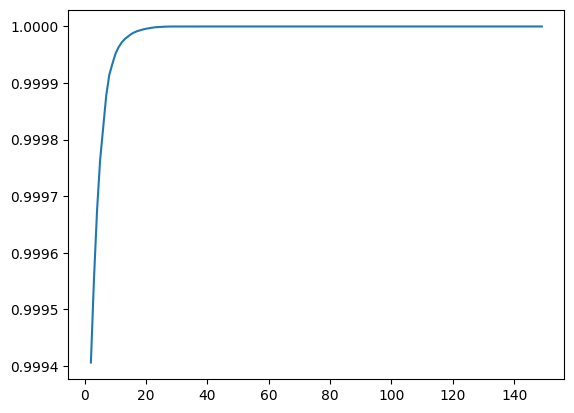

In [59]:
# plotting variance ratio
pd.Series(var_ratio).plot()

In [60]:
!pip install kneed

<Figure size 500x500 with 0 Axes>

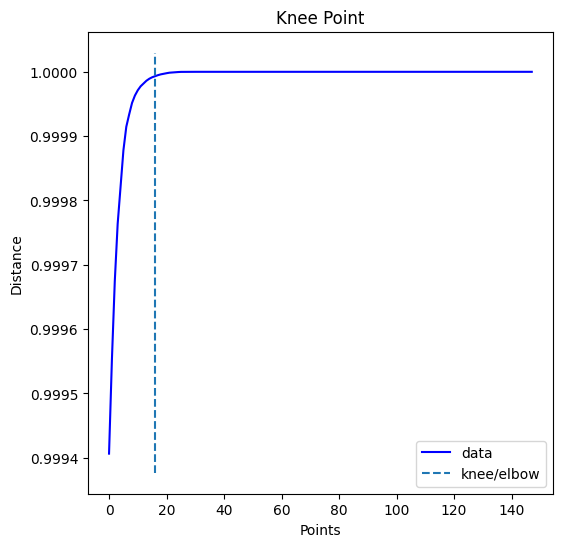

Knee Locator k = 18


In [61]:
from kneed import KneeLocator

i = np.arange(len(var_ratio))
variance_ratio= list(var_ratio.values())
components=  list(var_ratio.keys())
knee = KneeLocator(i, variance_ratio, S=1, curve='concave', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()
k= components[knee.knee]
print('Knee Locator k =', k)

In [62]:
# Reducing the dimensions of the data 
pca_final=PCA(n_components=18,random_state=42).fit(X_res)

reduced_train=pca_final.fit_transform(X_pca_train)
reduced_test=pca_final.transform(X_pca_test)

In [63]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1)
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(reduced_train, y_train)

In [64]:
report_pca = evaluate_models(X_res,y_res,reduced_test,y_test,models)

Random Forest
Model performance for Training set
- Accuracy: 0.9998
- F1 score: 0.9998
- Precision: 1.0000
- Recall: 0.9997
- Roc Auc Score: 0.9998
- COST: 3500.
----------------------------------
Model performance for Test set
- Accuracy: 0.9707
- F1 score: 0.5939
- Precision: 0.4814
- Recall: 0.7750
- Roc Auc Score: 0.8756
- COST: 24170.


Decision Tree
Model performance for Training set
- Accuracy: 0.9998
- F1 score: 0.9998
- Precision: 1.0000
- Recall: 0.9997
- Roc Auc Score: 0.9998
- COST: 3500.
----------------------------------
Model performance for Test set
- Accuracy: 0.9632
- F1 score: 0.5074
- Precision: 0.4029
- Recall: 0.6850
- Roc Auc Score: 0.8281
- COST: 33530.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9421
- F1 score: 0.9418
- Precision: 0.9470
- Recall: 0.9366
- Roc Auc Score: 0.9421
- COST: 674980.
----------------------------------
Model performance for Test set
- Accuracy: 0.9421
- F1 score: 0.4565
- Precision: 0.3082
- Recall: 0.8800
- R

In [65]:
report_pca

,Model Name,Cost
2,Gradient Boosting,15950
6,CatBoosting Classifier,18500
3,Logistic Regression,19160
7,AdaBoost Classifier,19810
0,Random Forest,24170
4,K-Neighbors Classifier,24780
5,XGBClassifier,26080
1,Decision Tree,33530


In [24]:
!pip install prettytable

In [25]:
from prettytable import PrettyTable

pt=PrettyTable()
pt.field_names=["Model","Imputation_method","Total_cost"]
pt.add_row(["Gradient Boosting","Simple Imputer-Median","13460"])
pt.add_row(["Gradient Boosting","Knn-Imputer","13470"])
pt.add_row(["Ada Boost","Simple Imputer-Constant","12590"])
pt.add_row(["Gradient Boosting","Simple Imputer-Mean","13940"])
pt.add_row(["Gradient Boosting","PCA","15950"])
print(pt)

+-------------------+-------------------------+------------+
|       Model       |    Imputation_method    | Total_cost |
+-------------------+-------------------------+------------+
| Gradient Boosting |  Simple Imputer-Median  |   13460    |
| Gradient Boosting |       Knn-Imputer       |   13470    |
|     Ada Boost     | Simple Imputer-Constant |   12590    |
| Gradient Boosting |   Simple Imputer-Mean   |   13940    |
| Gradient Boosting |           PCA           |   15950    |
+-------------------+-------------------------+------------+


**Here the best method to use is Gradient boosting with Simple Imputer Median**

**Hyperparameter tuning using optuna**

In [26]:
!pip install optuna

In [27]:
num_features = X_train.select_dtypes(exclude="object").columns

# Fit the Simple imputer with strategy median
median_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('RobustScaler', RobustScaler())
])

In [28]:
# Fit X with median_pipeline
X_median_train = median_pipeline.fit_transform(X_train)
X_median_val=median_pipeline.transform(X_val)
X_median_test=median_pipeline.transform(X_test)

In [29]:
# final_model = GradientBoostingClassifier()
from imblearn.combine import SMOTETomek
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1)
# Fit the model to generate the data.
X_resampled, y_resampled = smt.fit_resample(X_median_train, y_train)



In [30]:
import optuna
import lightgbm as lgb
from sklearn.metrics import accuracy_score
import logging

# Suppress Optuna logs except for warnings and errors
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Define your objective function for Optuna
def objective(trial):
    # Define the hyperparameter search space for LightGBM
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'device': 'gpu',
        'gpu_device_id': 1,
        'verbose': -1  # Suppress LightGBM output
    }

    # Initialize LightGBM Classifier with current trial's hyperparameters
    lgbm_clf = lgb.LGBMClassifier(
        **params,
        random_state=42,
        n_jobs=-1
    )

    # Train the classifier on the resampled training data
    lgbm_clf.fit(X_resampled, y_resampled)

    # Predict on the test data
    y_pred = lgbm_clf.predict(X_median_val)

    # Calculate the custom total score (accuracy in this case)
    score = total_cost(y_val, y_pred)

    return score

# Create a study object and specify that we want to minimize the custom cost
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Output the best trial results
print(f"Best trial: Cost {study.best_trial.value:.4f}, Parameters: {study.best_trial.params}")

# Retrieve the best parameters and fit the final model
best_params = study.best_trial.params
final_lgbm_clf = lgb.LGBMClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1,
    verbose=-1  # Suppress LightGBM output
)

# Fit the final model
final_lgbm_clf.fit(X_resampled, y_resampled)

# Predict and evaluate on validation set
y_final_pred_val = final_lgbm_clf.predict(X_median_val)
final_cost_val = total_cost(y_val, y_final_pred_val)
print(f"Final validation cost: {final_cost_val:.4f}")

# Predict and evaluate on test set
y_final_pred_test = final_lgbm_clf.predict(X_median_test)
final_cost_test = total_cost(y_test, y_final_pred_test)
print(f"Final test cost: {final_cost_test:.4f}")


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Best trial: Cost 9390.0000, Parameters: {'learning_rate': 0.0001120090913115774, 'num_leaves': 22, 'max_depth': 4, 'n_estimators': 495, 'min_child_samples': 16, 'subsample': 0.718024145186189, 'colsample_bytree': 0.5378400421712511, 'reg_alpha': 0.1705333838055798, 'reg_lambda': 6.529771573507214e-07}
Final validation cost: 9390.0000
Final test cost: 11510.0000


In [31]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_final_pred_test)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate precision, recall, and accuracy
precision = precision_score(y_test, y_final_pred_test)
recall = recall_score(y_test, y_final_pred_test)
accuracy = accuracy_score(y_test, y_final_pred_test)

# Calculate final test cost
final_cost_test = total_cost(y_test, y_final_pred_test)

# Print all metrics
print(f"Final Test Cost: {final_cost_test:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")


Confusion Matrix:
[[6737  301]
 [  17  183]]
Final Test Cost: 11510.0000
Precision: 0.3781
Recall: 0.9150
Accuracy: 0.9561


In [32]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_val, y_final_pred_val)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate precision and recall
precision = precision_score(y_val, y_final_pred_val)
recall = recall_score(y_val, y_final_pred_val)
accuracy = accuracy_score(y_val, y_final_pred_val)

final_cost_test = total_cost(y_val, y_final_pred_val)
print(f"Final test cost: {final_cost_test:.4f}")
# Print precision and recall
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")



Confusion Matrix:
[[6749  289]
 [  13  187]]
Final test cost: 9390.0000
Precision: 0.3929
Recall: 0.9350
Accuracy: 0.9583


In [ ]:
# !pip install optuna

In [ ]:
# # Hyperparameter tuning with Optuna and CatBoost
# import optuna
# from catboost import CatBoostClassifier
# from sklearn.metrics import accuracy_score

# # Define your objective function for Optuna
# def objective(trial):
#     # Define the hyperparameter search space
#     params = {
#         'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
#         'depth': trial.suggest_int('depth', 3, 15),
#         'iterations': trial.suggest_int('iterations', 100, 1500),
#         # 'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
#         # 'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.3, 1.0),
#         'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 10.0),
#         'random_strength': trial.suggest_loguniform('random_strength', 1e-8, 10.0),
#         'task_type': 'GPU',  # Use GPU for training
#         'devices': '0:1'     # Use GPUs 0 and 1 (if you have 2 GPUs available)
#     }

#     # Initialize CatBoost Classifier with current trial's hyperparameters
#     catboost_clf = CatBoostClassifier(
#         **params,
#         eval_metric='Accuracy',   # Metric for evaluation
#         verbose=100,              # Enable verbose logging every 100 iterations
#         random_seed=42
#     )

#     print(f"Trial with Parameters: {params}")  # Print the trial parameters for each run

#     # Train the classifier on the resampled training data
#     catboost_clf.fit(X_resampled, y_resampled)

#     # Predict on the test data
#     y_pred = catboost_clf.predict(X_median_test)

#     # Calculate the custom total score (accuracy in this case)
#     score = total_cost(y_test, y_pred)

#     # Return score (minimize cost)
#     return score

# # Create a study object and specify that we want to minimize the custom cost
# study = optuna.create_study(direction='minimize')  # Set direction to 'minimize' for cost
# study.optimize(objective, n_trials=50)  # You can adjust the number of trials

# # Output the best trial results
# print(f"Best trial: Cost {study.best_trial.value:.4f}, Parameters: {study.best_trial.params}")

# # Retrieve the best parameters and fit the final model
# best_params = study.best_trial.params
# final_catboost_clf = CatBoostClassifier(
#     **best_params,
#     eval_metric='Accuracy',
#     verbose=100,  # Enable verbose logging for the final model
#     random_seed=42
# )

# # Fit the final model
# final_catboost_clf.fit(X_resampled, y_resampled)

# # Predict on the test set
# y_final_pred = final_catboost_clf.predict(X_median_test)

# # Evaluate the final model
# final_accuracy = accuracy_score(y_test, y_final_pred)
# print(f"Final Model Accuracy: {final_accuracy:.4f}")


In [ ]:
# # Hyperparameter tuning with Optuna
# import optuna
# import xgboost as xgb
# from sklearn.model_selection import train_test_split


# # Define your objective function for Optuna
# def objective(trial):
#     # Define the hyperparameter search space
#     params = {
#         'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
#         'max_depth': trial.suggest_int('max_depth', 3, 15),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
#         'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3, 1.0),
#         'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
#         'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
#         'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
#         'tree_method': 'gpu_hist',  # Use GPU
#         'gpu_id': 0
#     }

#     # Initialize XGBoost Classifier with current trial's hyperparameters
#     xgb_clf = xgb.XGBClassifier(**params)

#     # Train the classifier on the resampled training data
#     xgb_clf.fit(X_resampled, y_resampled)

#     # Predict on the test data
#     y_pred = xgb_clf.predict(X_median_test)

#     # Calculate the custom total score
#     score = total_cost(y_test, y_pred)  # Using your custom metric

#     return score  # Optuna will maximize this value if it's a positive metric or minimize if it's a cost

# # Create a study object and specify that we want to maximize the custom total score
# study = optuna.create_study(direction='minimize')  # Use 'maximize' if your custom score is meant to be maximized
# study.optimize(objective, n_trials=50)  # You can adjust the number of trials

# # Output the best trial results
# print(f"Best trial: Total score {study.best_trial.value:.4f}, Parameters: {study.best_trial.params}")


In [ ]:
# # Hyperparameter tuning with Optuna
# import optuna
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.model_selection import train_test_split

# # Define your objective function for Optuna
# def objective(trial):
#     # Define the hyperparameter search space
#     params = {
#         'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
#         'max_depth': trial.suggest_int('max_depth', 3, 15),
#         'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
#         'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2', None]),
#         'random_state': 42
#     }

#     # Initialize GradientBoostingClassifier with current trial's hyperparameters
#     gbc_clf = GradientBoostingClassifier(**params)

#     # Train the classifier on the resampled training data
#     gbc_clf.fit(X_resampled, y_resampled)

#     # Predict on the test data
#     y_pred = gbc_clf.predict(X_median_test)

#     # Calculate the custom total score
#     score = total_cost(y_test, y_pred)  # Using your custom metric

#     return score  # Optuna will minimize this value if it's a cost

# # Create a study object and specify that we want to minimize the custom total score
# study = optuna.create_study(direction='minimize')  # Use 'maximize' if your custom score is meant to be maximized
# study.optimize(objective, n_trials=50)  # You can adjust the number of trials

# # Output the best trial results
# print(f"Best trial: Total score {study.best_trial.value:.4f}, Parameters: {study.best_trial.params}")
